In [ ]:
#pip install transformers datasets pandas scikit-learn

In [ ]:
# CLEAR CACHE 
import gc
import torch
gc.collect()

torch.cuda.empty_cache()

## Loading Model, dataset and definitions

In [1]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, set_seed
from datasets import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import random
from transformers import TrainerCallback

# Load the saved model and tokenizer
model_path = './saved_model_Roberta_large_augmented'
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)


# Plot confusion matrix

def plot_confusion_matrix(test_labels, pred_labels):
    cm = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violent', 'Violent'], yticklabels=['Non-Violent', 'Violent'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(test_labels, predictions):
    fpr, tpr, _ = roc_curve(test_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.8f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


# Load the dataset
train_file_path = 'history_train_simplified.csv'  # Update with the correct file path
test_file_path = 'history_test.csv'  # Update with the correct file path

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Split the training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_df['Text'], train_df['Violence'], test_size=0.2, random_state=42)
test_texts = test_df['Text']
test_labels = test_df['Violence']

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'label': list(train_labels)})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'label': list(val_labels)})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    per_device_eval_batch_size=16,    # batch size for evaluation

)

# Initialize the custom callback

# Define Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
)


2024-07-31 17:45:21.373101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 17:45:21.386083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:45:21.400734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:45:21.405220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:45:21.416945: I tensorflow/core/platform/cpu_feature_guar

## Test on the test set

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Overall Precision on Test Set: 0.9836
Overall Recall on Test Set: 0.9302
Overall F1 Score on Test Set: 0.9562
Overall Accuracy on Test Set: 0.9780
              precision    recall  f1-score   support

 Non-Violent       0.98      0.99      0.99       371
     Violent       0.98      0.93      0.96       129

    accuracy                           0.98       500
   macro avg       0.98      0.96      0.97       500
weighted avg       0.98      0.98      0.98       500



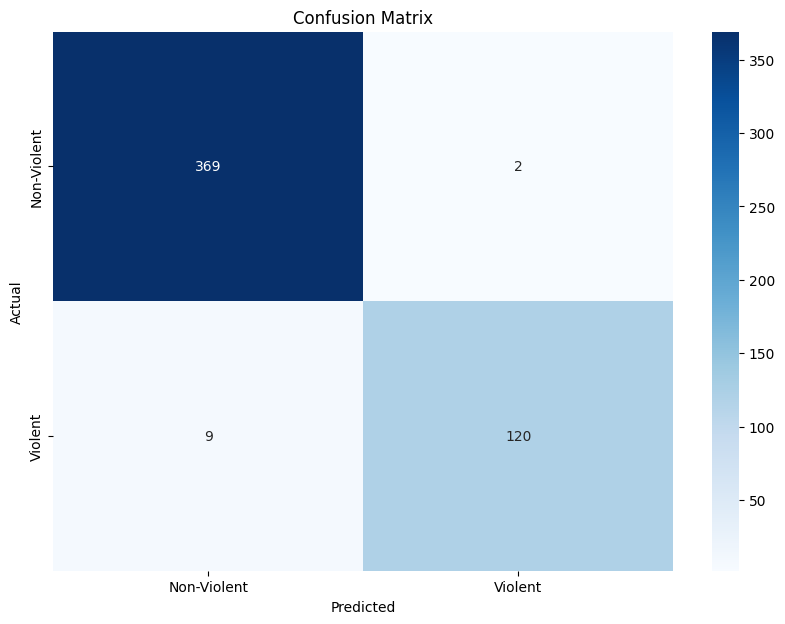

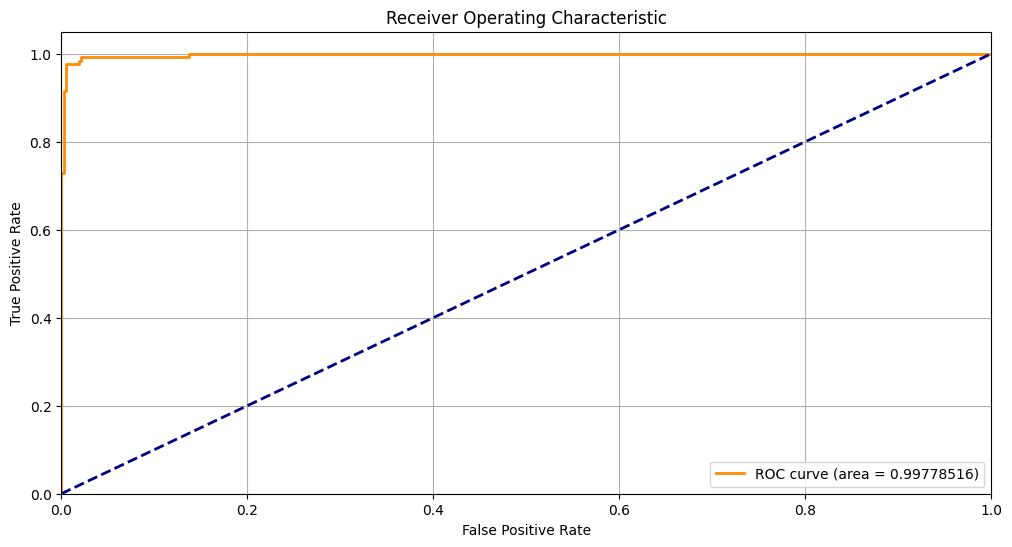


Misclassified Test Sentences:
--------------------------------------------------
Sentence: 
But since it proved too hard a task to break the Theban front, they were forced to do what at the outset they were loth to do. They opened their ranks and let the enemy pass through, and then, when these had got clear, and were already marching in looser array, the Spartans followed on the run and smote them on the flanks. They could not, however, put them to rout, but the Thebans withdrew to Mount Helicon, From the slopes of which they had advanced to the battle. greatly elated over the battle, in which, as they reasoned, their own contingent had been undefeated.
Actual Label: Non-Violent | Predicted Label: Violent
--------------------------------------------------
Sentence: 
When he heard this, Alexander ordered the leaders themselves to fight in single combat; to the one called Alexander he himself gave armour, and to the one called Dareius, Philotas. The army were spectators of the combat, 

In [2]:
# Evaluate the model on the test set
predictions_test_set = trainer.predict(test_dataset)

# Convert predictions to label IDs
pred_labels_test_set = np.argmax(predictions_test_set.predictions, axis=1)

# Calculate overall metrics
precision_test_set = precision_score(test_labels, pred_labels_test_set)
recall_test_set = recall_score(test_labels, pred_labels_test_set)
f1_test_set = f1_score(test_labels, pred_labels_test_set)
accuracy_test_set = accuracy_score(test_labels, pred_labels_test_set)

print(f'Overall Precision on Test Set: {precision_test_set:.4f}')
print(f'Overall Recall on Test Set: {recall_test_set:.4f}')
print(f'Overall F1 Score on Test Set: {f1_test_set:.4f}')
print(f'Overall Accuracy on Test Set: {accuracy_test_set:.4f}')

# Generate classification report for both classes
report_test_set = classification_report(test_labels, pred_labels_test_set, target_names=['Non-Violent', 'Violent'])
print(report_test_set)

# Plot the confusion matrix for the test set
plot_confusion_matrix(test_labels, pred_labels_test_set)

# Plot the ROC curve for the test set
plot_roc_curve(test_labels, predictions_test_set.predictions)

# Print misclassified test sentences with their predicted and actual labels
test_sentences = list(test_texts)
print("\nMisclassified Test Sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(test_sentences, test_labels, pred_labels_test_set):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)


## Test on the whole data

Size of combined dataset: 2564
Expected size (train + val + test): 2564


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Overall Precision on Combined Set: 0.9909
Overall Recall on Combined Set: 0.9436
Overall F1 Score on Combined Set: 0.9667
Overall Accuracy on Combined Set: 0.9883
              precision    recall  f1-score   support

 Non-Violent       0.99      1.00      0.99      2103
     Violent       0.99      0.94      0.97       461

    accuracy                           0.99      2564
   macro avg       0.99      0.97      0.98      2564
weighted avg       0.99      0.99      0.99      2564



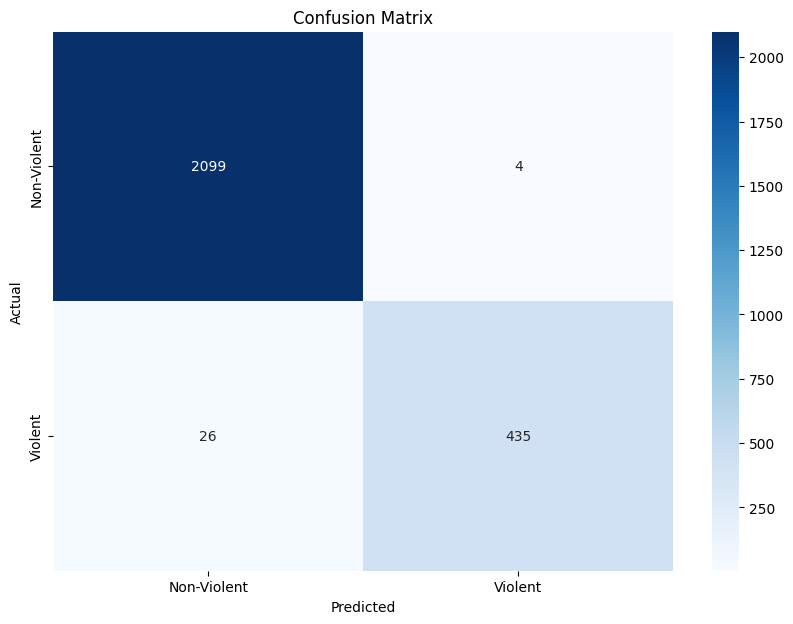

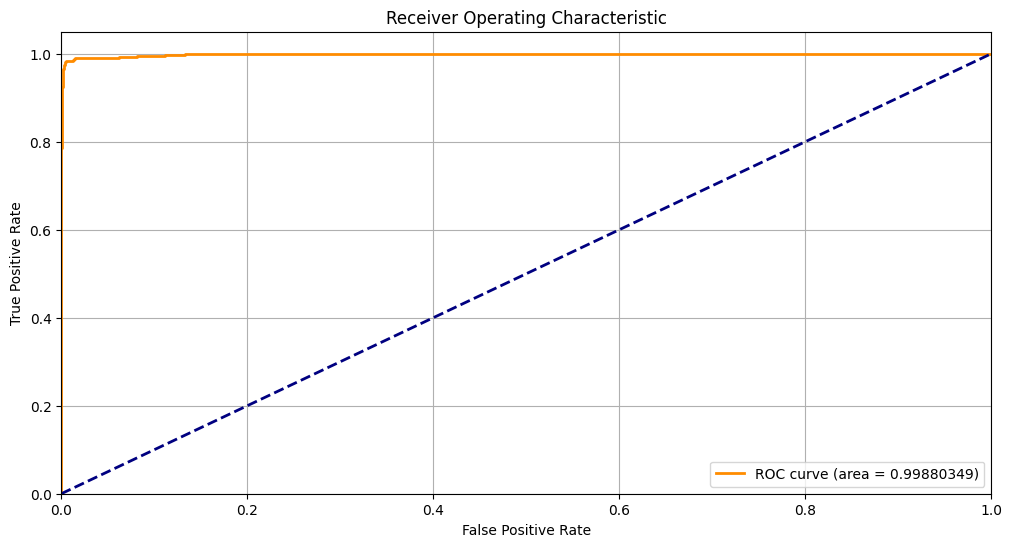


Misclassified test sentences:
--------------------------------------------------
Sentence: 
With these words, he retired into the temple, and taking a scroll, as if about to write, he put his pen to his mouth and bit it, as he was wont to do when thinking what he should write, and kept it there some time, then covered and bent his head. The spear-men, then, who stood at the door, laughed at him for playing the coward, and called him weak and unmanly, but Archias came up and urged him to rise, and reiterating the same speeches as before, promised him a reconciliation with Antipater. But Demosthenes, now conscious that the poison was affecting and overpowering him, uncovered his head; and fixing his eyes upon Archias, ‘Thou canst not be too soon now,’ said he, ‘in playing the part of Creon in the tragedy and casting this body out without burial. But I, O beloved Poseidon, will depart from thy sanctuary while I am still alive; whereas Antipater and the Macedonians would not have left eve

In [3]:
# Combine training, validation, and test datasets
combined_texts = list(train_texts) + list(val_texts) + list(test_texts)
combined_labels = list(train_labels) + list(val_labels) + list(test_labels)

# Tokenize the combined dataset
combined_encodings = tokenizer(combined_texts, truncation=True, padding=True)
combined_dataset = Dataset.from_dict({'input_ids': combined_encodings['input_ids'], 'attention_mask': combined_encodings['attention_mask'], 'label': combined_labels})

# Ensure that the dataset sizes match
print(f"Size of combined dataset: {len(combined_dataset)}")
print(f"Expected size (train + val + test): {len(train_texts) + len(val_texts) + len(test_texts)}")

# Evaluate the model on the whole dataset
predictions_combined_set = trainer.predict(combined_dataset)

# Convert predictions to label IDs
pred_labels_combined_set = np.argmax(predictions_combined_set.predictions, axis=1)

# Calculate overall metrics
precision_combined_set = precision_score(combined_labels, pred_labels_combined_set)
recall_combined_set = recall_score(combined_labels, pred_labels_combined_set)
f1_combined_set = f1_score(combined_labels, pred_labels_combined_set)
accuracy_combined_set = accuracy_score(combined_labels, pred_labels_combined_set)

print(f'Overall Precision on Combined Set: {precision_combined_set:.4f}')
print(f'Overall Recall on Combined Set: {recall_combined_set:.4f}')
print(f'Overall F1 Score on Combined Set: {f1_combined_set:.4f}')
print(f'Overall Accuracy on Combined Set: {accuracy_combined_set:.4f}')

# Generate classification report for both classes
report_combined_set = classification_report(combined_labels, pred_labels_combined_set, target_names=['Non-Violent', 'Violent'])
print(report_combined_set)

# Plot the confusion matrix for the combined dataset
plot_confusion_matrix(combined_labels, pred_labels_combined_set)

# Plot the ROC curve for the combined dataset
plot_roc_curve(combined_labels, predictions_combined_set.predictions)

# Print misclassified sentences with their predicted and actual labels for the combined dataset
print("\nMisclassified test sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(combined_texts, combined_labels, pred_labels_combined_set):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)


## Test on Random seed 42 

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Overall Precision on Test Set: 0.9896
Overall Recall on Test Set: 0.9314
Overall F1 Score on Test Set: 0.9596
Overall Accuracy on Test Set: 0.9844
              precision    recall  f1-score   support

 Non-Violent       0.98      1.00      0.99       411
     Violent       0.99      0.93      0.96       102

    accuracy                           0.98       513
   macro avg       0.99      0.96      0.97       513
weighted avg       0.98      0.98      0.98       513



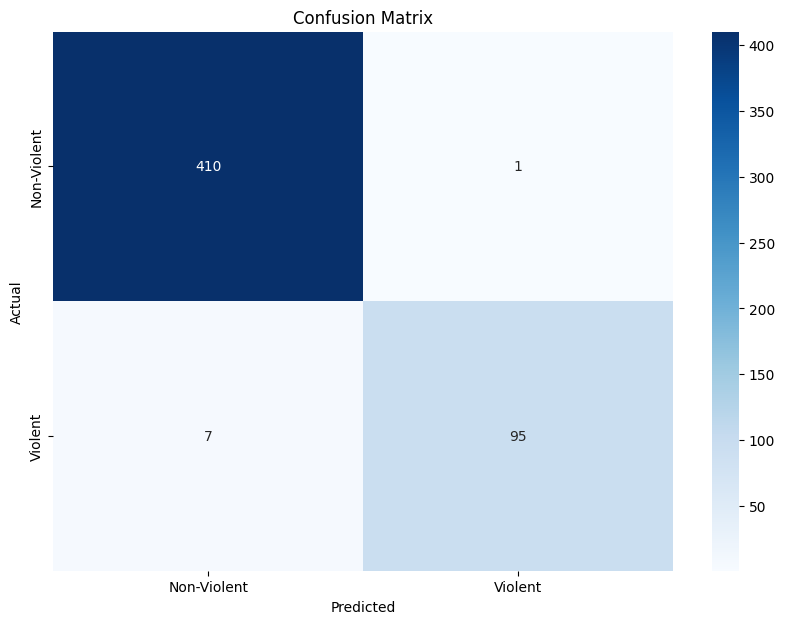

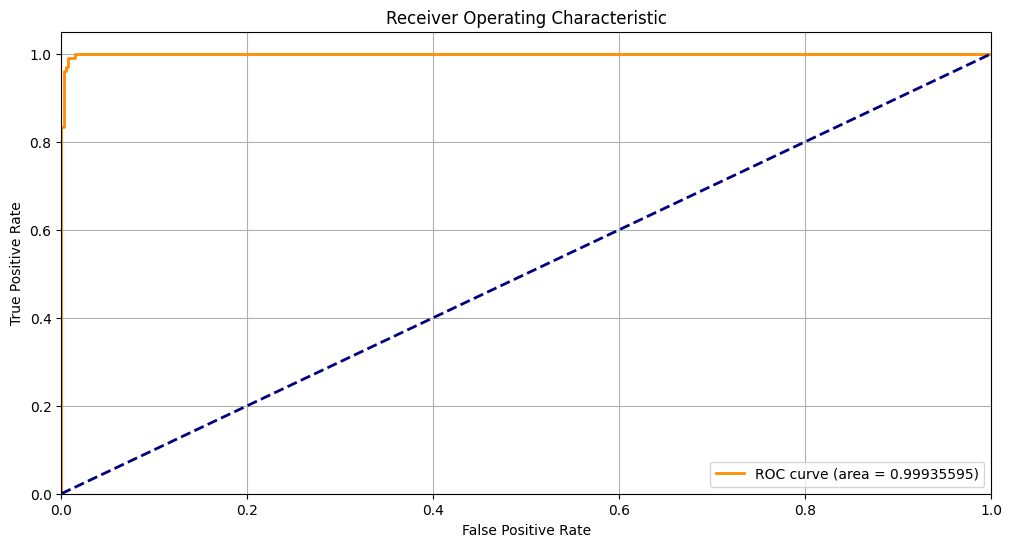


Misclassified Test Sentences:
--------------------------------------------------
Sentence: 
when in her alone of Greek cities they saw the most conspicuous temples, not adorned with Greek spoils, nor possessed of joyless memorials in the shape of votive offerings from the slaughter of kinsmen and fellow citizens, but decked with barbarian spoils which set forth in fairest inscriptions the justice as well as the valour of the victors, declaring that Corinthians and Timoleon their general set the Greeks dwelling in Sicily free from Carthaginians, and thus dedicated thank-offerings to the gods.
Actual Label: Violent | Predicted Label: Non-Violent
--------------------------------------------------
Sentence: 
But since it proved too hard a task to break the Theban front, they were forced to do what at the outset they were loth to do. They opened their ranks and let the enemy pass through, and then, when these had got clear, and were already marching in looser array, the Spartans followed o

In [4]:

# Load the entire dataset
dataset_file_path = 'cleaned_history_text.csv'
df = pd.read_csv(dataset_file_path)

# Split the dataset into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Violence'], test_size=0.2, random_state=42)

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'label': list(train_labels)})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})


# Evaluate the model on the test set
predictions_test_set = trainer.predict(test_dataset)

# Convert predictions to label IDs
pred_labels_test_set = np.argmax(predictions_test_set.predictions, axis=1)

# Calculate overall metrics
precision_test_set = precision_score(test_labels, pred_labels_test_set)
recall_test_set = recall_score(test_labels, pred_labels_test_set)
f1_test_set = f1_score(test_labels, pred_labels_test_set)
accuracy_test_set = accuracy_score(test_labels, pred_labels_test_set)

print(f'Overall Precision on Test Set: {precision_test_set:.4f}')
print(f'Overall Recall on Test Set: {recall_test_set:.4f}')
print(f'Overall F1 Score on Test Set: {f1_test_set:.4f}')
print(f'Overall Accuracy on Test Set: {accuracy_test_set:.4f}')

# Generate classification report for both classes
report_test_set = classification_report(test_labels, pred_labels_test_set, target_names=['Non-Violent', 'Violent'])
print(report_test_set)

# Plot the confusion matrix for the test set
plot_confusion_matrix(test_labels, pred_labels_test_set)

# Plot the ROC curve for the test set
plot_roc_curve(test_labels, predictions_test_set.predictions)

# Print misclassified test sentences with their predicted and actual labels
test_sentences = list(test_texts)
print("\nMisclassified Test Sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(test_sentences, test_labels, pred_labels_test_set):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)


## Predict New input

In [ ]:
import torch
# Define a function to classify new sentences
def classify_new_sentences(sentences, model, tokenizer):
    # Tokenize the new sentences
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
    
    # Convert logits to probabilities and then to labels
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1).cpu().numpy()
    
    return pred_labels

# Example usage
new_sentences = [
   
    # George Orwell
    "The most effective way to destroy people is to deny and obliterate their own understanding of their history.",
    # Dan Brown
    "History is always written by the winners. When two cultures clash, the loser is obliterated, and the winner writes the history books. Books, which glorify their own cause and disparage the conquered foe. As Napoleon once said, what is history, but a fable agreed upon? ",
    # Sun Tzu
    "If you know the enemy and know yourself, you need not fear the result of a hundred battles. If you know yourself but not the enemy, for every victory gained you will also suffer a defeat. If you know neither the enemy nor yourself, you will succumb in every battle.",
    # Winston Churchill
    "We shall defend our island, whatever the cost may be, we shall fight on the beaches, we shall fight on the landing grounds, we shall fight in the fields and in the streets, we shall fight in the hills; we shall never surrender.",
    # Robert Kennedy
    "What has violence ever accomplished? What has it ever created? No martyr's cause has ever been stilled by an assassin's bullet. No wrongs have ever been righted by riots and civil disorders. A sniper is only a coward, not a hero; and an uncontrolled or uncontrollable mob is only the voice of madness, not the voice of the people.",
    
    
    "While the Romans were in such difficulties, the barbarians suddenly surrounded them on all sides at once, coming through the densest thickets, as they were acquainted with the paths. At first they hurled their volleys from a distance; then, as no one defended himself and many were wounded, they approached closer to them. For the Romans were not proceeding in any regular order, but were mixed in helter-skelter with the waggons and the unarmed, and so, being unable to form readily anywhere in a body, and being fewer at every point than their assailants, they suffered greatly and could offer no resistance at all.",
    "In the battle, the knight broke the lines and slaughtered his enemies and then beheaded the king.",
    "I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character.",
    "You can fool all of the people some of the time, and some of the people all of the time, but you can't fool all of the people all of the time.",
    "Battles are won by slaughter and maneuver. The greater the general, the more he contributes in maneuver, the less he demands in slaughter.",
    "Remembering the loss of those Irishmen from all parts of the island who were sent to their deaths in the imperialist slaughter of the First World War is crucial to understanding our history. It is also important to recognise the special significance in which the Battle of the Somme and the First World War is held.",
    "In the battle, the soldiers started counting the sheeps that they got as a reward for their awersome performance. They managed to cheer the crowds and support the winners ",
    "The knight killed her and her mother watched in pain as he beheads her",
    "The knight kissed her and she loved it. Then we went walking and talked about some love stories",
    
]
pred_labels = classify_new_sentences(new_sentences, model, tokenizer)


# Print predictions with better formatting
print("Predictions for New Sentences:")
print("-" * 50)
for sentence, label in zip(new_sentences, pred_labels):
    print(f"Sentence: \n{sentence}\nPredicted Label: {'Violent' if label == 1 else 'Non-Violent'}")
    print("-" * 50)

## Parameter Number

In [ ]:
print(f'{sum(p.numel() for p in model.parameters())}')

In [ ]:
train_df.shape[0]
#test_df.shape[0]

## Trying without Finetuning

In [ ]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, set_seed
from datasets import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import random

# Set seeds for reproducibility
def set_all_seeds(seed):
    import random
    import numpy as np
    import torch
    from transformers import set_seed

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

set_all_seeds(42)

start_time = time.time()
# Load the dataset
file_path = 'cleaned_history_text.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Violence'], test_size=0.2, random_state=42)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Tokenize the text
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})

# Load the pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

# Function to classify new sentences
def classify_new_sentences(sentences, model, tokenizer):
    # Tokenize the new sentences
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    
    # Move to device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
    
    # Convert logits to probabilities and then to labels
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1).cpu().numpy()
    
    return pred_labels
# Plot confusion matrix
def plot_confusion_matrix(test_labels, pred_labels):
    cm = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violent', 'Violent'], yticklabels=['Non-Violent', 'Violent'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(test_labels, predictions):
    fpr, tpr, _ = roc_curve(test_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
# Evaluate the pre-trained model on the test set
test_texts_list = list(test_texts)
pred_labels = classify_new_sentences(test_texts_list, model, tokenizer)

# Calculate overall metrics
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)
accuracy = accuracy_score(test_labels, pred_labels)

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')

# Generate classification report for both classes
report = classification_report(test_labels, pred_labels, target_names=['Non-Violent', 'Violent'])
print(report)

end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels)

# Since we are using a pre-trained model without fine-tuning, predictions will be logits
pred_probs = np.array([torch.nn.functional.softmax(torch.tensor(logits), dim=0).numpy() for logits in model(**tokenizer(test_texts_list, return_tensors='pt', padding=True, truncation=True)).logits])

# Plot the ROC curve
plot_roc_curve(test_labels, pred_probs)


# Print misclassified test sentences with their predicted and actual labels
print("\nMisclassified Test Sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(test_texts_list, test_labels, pred_labels):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)





# Example usage for new sentence classification
new_sentences = [
    "This is a peaceful example.",
    "He killed and beheaded all enemies."
]
pred_labels = classify_new_sentences(new_sentences, model, tokenizer)

# Print predictions with better formatting
print("Predictions for New Sentences:")
print("-" * 50)
for sentence, label in zip(new_sentences, pred_labels):
    print(f"Sentence: \n{sentence}\nPredicted Label: {'Violent' if label == 1 else 'Non-Violent'}")
    print("-" * 50)


## TEST LATER FOR BETTER HYPERPARAMETERS

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
import numpy as np
import torch

# Load the dataset
file_path = 'history_text.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Violence'], test_size=0.2, random_state=42)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'label': list(train_labels)})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    learning_rate=2e-5,              # Adjust learning rate
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    eval_steps=10,
    load_best_model_at_end=True,     # Load the best model at the end
    metric_for_best_model="f1",      # Define the metric to use for early stopping
    greater_is_better=True,
)

# Define a function to compute metrics
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision = precision_score(labels, pred)
    recall = recall_score(labels, pred)
    f1 = f1_score(labels, pred)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping
)

# Train the model
trainer.train()

# Evaluate the model on the test set
predictions = trainer.predict(test_dataset)

# Convert predictions to label IDs
pred_labels = np.argmax(predictions.predictions, axis=1)

# Calculate and print metrics
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)
accuracy = accuracy_score(test_labels, pred_labels)

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')

# Generate classification report for both classes
report = classification_report(test_labels, pred_labels, target_names=['Non-Violent', 'Violent'])
print(report)
